## Installs and Imports

In [1]:
!pip install lightning
!pip install wandb
!pip install -qqq wandb pytorch-lightning
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 7.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinu

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import torchvision.datasets as datasets
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import wandb
from pytorch_lightning.loggers import WandbLogger
from torch.optim.lr_scheduler import StepLR
from lightning.pytorch.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from sklearn.model_selection import train_test_split
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models


wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Data

In [64]:
data = []

for r in range(1000):

    # initialising dimentions d1 and d2 with random numbers
    d1 = []
    d2 = []

    for i in range(100):
        d1.append((random.random()) - 0.5)
        d2.append((random.random()) - 0.5)

    # initializing length of signal 'l' in dimension d1 & d2
    l = (random.randint(10, len(d1)/2))
    # print('length of main signal = ', l)

    # initializing the point 'm' from where the signal starts
    m = (random.randint(0, (len(d1)-l)))
    # print('The signal starts from index ', m)

    # # Initialising the three signals s1, s2 and s3 in dimension d2
    # print('Signal s1 is triangular wave')
    # print('Signal s2 is square wave')
    # print('Signal s3 is downward semicircular wave')

    # s1 - triangular wave
    def s1(t):
        if t < 0.5:
            return t
        else:
            return 1 - t

    # s2 - square wave
    def s2(t):
        if 0 <= t < 0.5:
            return 0.5
        else:
            return -0.5

    # s3 - lower semicircle
    def s3(t):
        return (-(0.5**2 - (t - 0.5)**2)**0.5)

    # selecting either of s1, s2 or s3 at random
    p = random.randint(1,3)
    # print('Target signal of s', p, ' is selected')

    # Inputting the signals in the respective dimensions
    for i in range(l):

        d1[m] = (np.sin(i*2*np.pi/(l-1)))/2

        j = i/(l-1)
        if p == 1:
            d2[m] = s1(j)
        if p == 2:
            d2[m] = s2(j)
        if p == 3:
            d2[m] = s3(j)

        m += 1

    if len(d2) - m >= 10:

        ps = random.randint(1,3)
        # print('Post signal of s', ps, ' is selected')

        Q = random.randint(10, min((len(d1) - m), 50))
        # print('Post noise is of length = ', Q)

        R = random.randint(0, (len(d1) - m - Q))

        post = m + R
        # print('Post noise starts from index ', post)

        for i in range(Q):
            j = i/(Q-1)
            if ps == 1:
                d2[post] = s1(j)
            if ps == 2:
                d2[post] = s2(j)
            if ps == 3:
                d2[post] = s3(j)

            post += 1

    if (m - l) >= 10:

        bs = random.randint(1,3)
        # print('Pre signal of s', bs, ' is selected')

        Qn = random.randint(10, min((m - l), 50))
        # print('Pre noise is of length = ', Qn)

        Rn = random.randint(0, (m - l - Qn))

        pre = Rn
        # print('Pre noise starts from index ', pre)

        for i in range(Qn):
            j = i/(Qn-1)
            if bs == 1:
                d2[pre] = s1(j)
            if bs == 2:
                d2[pre] = s2(j)
            if bs == 3:
                d2[pre] = s3(j)

            pre += 1

    Batch = (d1, d2, p-1)
    data.append(Batch)

print('data stored')

data stored


In [65]:
# initialising dimentions d1 and d2 with random numbers
d1 = []
d2 = []

for i in range(100):
    d1.append((random.random()) - 0.5)
    d2.append((random.random()) - 0.5)

# initializing length of signal 'l' in dimension d1 & d2
l = (random.randint(10, len(d1)/2))
# print('length of main signal = ', l)

# initializing the point 'm' from where the signal starts
m = (random.randint(0, (len(d1)-l)))
# print('The signal starts from index ', m)

# # Initialising the three signals s1, s2 and s3 in dimension d2
# print('Signal s1 is triangular wave')
# print('Signal s2 is square wave')
# print('Signal s3 is downward semicircular wave')

# s1 - triangular wave
def s1(t):
    if t < 0.5:
        return t
    else:
        return 1 - t

# s2 - square wave
def s2(t):
    if 0 <= t < 0.5:
        return 0.5
    else:
        return -0.5

# s3 - lower semicircle
def s3(t):
    return (-(0.5**2 - (t - 0.5)**2)**0.5)

# selecting either of s1, s2 or s3 at random
p = random.randint(1,3)
print('Target signal of s', p - 1, ' is selected')

# Inputting the signals in the respective dimensions
for i in range(l):

    d1[m] = (np.sin(i*2*np.pi/(l-1)))/2

    j = i/(l-1)
    if p == 1:
        d2[m] = s1(j)
    if p == 2:
        d2[m] = s2(j)
    if p == 3:
        d2[m] = s3(j)

    m += 1

if len(d2) - m >= 10:

    ps = random.randint(1,3)
    # print('Post signal of s', ps, ' is selected')

    Q = random.randint(10, min((len(d1) - m), 50))
    # print('Post noise is of length = ', Q)

    R = random.randint(0, (len(d1) - m - Q))

    post = m + R
    # print('Post noise starts from index ', post)

    for i in range(Q):
        j = i/(Q-1)
        if ps == 1:
            d2[post] = s1(j)
        if ps == 2:
            d2[post] = s2(j)
        if ps == 3:
            d2[post] = s3(j)

        post += 1

if (m - l) >= 10:

    bs = random.randint(1,3)
    # print('Pre signal of s', bs, ' is selected')

    Qn = random.randint(10, min((m - l), 50))
    # print('Pre noise is of length = ', Qn)

    Rn = random.randint(0, (m - l - Qn))

    pre = Rn
    # print('Pre noise starts from index ', pre)

    for i in range(Qn):
        j = i/(Qn-1)
        if bs == 1:
            d2[pre] = s1(j)
        if bs == 2:
            d2[pre] = s2(j)
        if bs == 3:
            d2[pre] = s3(j)

        pre += 1

sampleIn = [d1 + d2]


Target signal of s 0  is selected


## FFN

### Lightning

In [ ]:
# Separate inputs and targets
device = torch.device("cuda")
inputs = []
targets = []
for i in data:
    inputs.append(i[0] + i[1])
    targets.append(i[2])

# Convert to numpy arrays
inputs = np.array(inputs)
targets = np.array(targets)

# Split data into training and testing sets
train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, targets, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors
train_inputs = torch.tensor(train_inputs, dtype=torch.float32).to(device)
test_inputs = torch.tensor(test_inputs, dtype=torch.float32).to(device)
train_targets = torch.tensor(train_targets, dtype=torch.long).to(device)  # Assuming targets are indices
test_targets = torch.tensor(test_targets, dtype=torch.long).to(device)


# Define LightningModule
class SimpleNN(pl.LightningModule):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 64)
        self.fc4 = torch.nn.Linear(64, num_classes)
        self.train_dataset = None
        self.test_dataset = None

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.softmax(self.fc4(x), dim=1)
        return x

    def prepare_data(self):
        self.train_dataset = TensorDataset(train_inputs, train_targets)
        self.test_dataset = TensorDataset(test_inputs, test_targets)

    def train_dataloader(self):
        train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        return train_loader

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        correct = (preds == y).sum().item()
        total = len(y)
        accuracy = correct / total
        self.log('train_loss', loss)
        self.log('train_accuracy', accuracy, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def test_dataloader(self):
        test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)
        return test_loader

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = torch.nn.functional.cross_entropy(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        correct = (preds == y).sum().item()
        total = len(y)
        accuracy = correct / total
        self.log("test_loss", test_loss, on_step=False, on_epoch=True)
        self.log("test_accuracy", accuracy, on_step=False, on_epoch=True)
        return {'test_loss': test_loss }

# Train the model
input_size = train_inputs.shape[1]
num_classes = 3  # Assuming 3 classes
model = SimpleNN(input_size, num_classes)
trainer = pl.Trainer(accelerator="gpu", max_epochs=11)
trainer.fit(model)

# Evaluate the model
trainer.test()


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 25.7 K
1 | fc2  | Linear | 8.3 K 
2 | fc3  | Linear | 4.2 K 
3 | fc4  | Linear | 195   
--------------------------------
38.3 K    Trainable params
0         Non-trainable params
38.3 K    Total params
0.153     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=11` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_7/checkpoints/epoch=10-step=2750.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_7/checkpoints/epoch=10-step=2750.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8939999938011169     │
│         test_loss         │    0.6541454195976257     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6541454195976257, 'test_accuracy': 0.8939999938011169}]

### Tensorflow

In [ ]:
# Separate inputs and targets
inputs = []
targets = []
for i in data:
    inputs.append(i[0] + i[1])
    targets.append(i[2])

# Split data into training and testing sets
train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, targets, test_size=0.2, random_state=42)

# Define a simple feed-forward neural network model
def create_model():
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(len(train_inputs[0]),)),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(3, activation='softmax')  # Assuming 3 classes
    ])
    return model

# Compile the model
model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Convert data to numpy arrays
train_inputs = tf.convert_to_tensor(train_inputs)
test_inputs = tf.convert_to_tensor(test_inputs)
train_targets = tf.convert_to_tensor(train_targets)
test_targets = tf.convert_to_tensor(test_targets)

# Train the model
model.fit(train_inputs, train_targets, epochs=10, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)
print(f'Test accuracy: {test_accuracy}')

Epoch 1/10
250/250 [==============================] - 1s 2ms/step - loss: 0.5564 - accuracy: 0.7745
Epoch 2/10
250/250 [==============================] - 1s 2ms/step - loss: 0.2497 - accuracy: 0.9022
Epoch 3/10
250/250 [==============================] - 1s 2ms/step - loss: 0.1409 - accuracy: 0.9524
Epoch 4/10
250/250 [==============================] - 1s 4ms/step - loss: 0.0691 - accuracy: 0.9779
Epoch 5/10
250/250 [==============================] - 1s 4ms/step - loss: 0.0302 - accuracy: 0.9929
Epoch 6/10
250/250 [==============================] - 1s 4ms/step - loss: 0.0140 - accuracy: 0.9971
Epoch 7/10
250/250 [==============================] - 1s 2ms/step - loss: 0.0070 - accuracy: 0.9989
Epoch 8/10
250/250 [==============================] - 1s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 9/10
250/250 [==============================] - 1s 2ms/step - loss: 7.3126e-04 - accuracy: 1.0000
Epoch 10/10
63/63 [==============================] - 0s 2ms/step - loss: 0.3935 - accuracy: 0.91

In [ ]:
# Make predictions on the testing data
predictions = model.predict(sampleIn)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print the predicted class labels
print("Predicted Class Labels:")
print(predictions)

1/1 [==============================] - 0s 232ms/step
Predicted Class Labels:
[[4.5810682e-12 1.0570144e-08 1.0000000e+00]]


## CNN

In [ ]:
# Hyperparameters
batch_size = 32
num_epochs = 10

device = torch.device("cuda")
inputs = []
targets = []
for i in data:
    A = []
    A.append(i[0])
    A.append(i[1])
    inputs.append(A)
    targets.append(i[2])

# Split data into training and testing sets
train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, targets, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors
train_inputs = torch.tensor(train_inputs, dtype=torch.float32).to(device)
test_inputs = torch.tensor(test_inputs, dtype=torch.float32).to(device)
train_targets = torch.tensor(train_targets, dtype=torch.long).to(device)
test_targets = torch.tensor(test_targets, dtype=torch.long).to(device)

class CNNClassifier(pl.LightningModule):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 23, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def prepare_data(self):
        self.train_dataset = TensorDataset(train_inputs, train_targets)
        self.test_dataset = TensorDataset(test_inputs, test_targets)

    def train_dataloader(self):
        train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        return train_loader

    def test_dataloader(self):
        test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)
        return test_loader

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        pred = torch.argmax(y_hat, dim=1)
        accuracy = (pred == y).float().mean()
        self.log('test_accuracy', accuracy)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# Initialize model
model = CNNClassifier()

# Initialize Lightning Trainer
trainer = pl.Trainer(accelerator = "gpu", max_epochs = num_epochs + 1)

# Train the model
trainer.fit(model, train_loader)

# Test the model
trainer.test()


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv1d | 224   
1 | conv2 | Conv1d | 6.2 K 
2 | fc1   | Linear | 188 K 
3 | fc2   | Linear | 387   
---------------------------------
195 K     Trainable params
0         Non-trainable params
195 K     Total params
0.781     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=11` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_7/checkpoints/epoch=10-step=2750.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_7/checkpoints/epoch=10-step=2750.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9994999766349792     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.9994999766349792}]

## Hyena Hierarchy Lightning

In [66]:
def fftconv(u, k, D):
    seqlen = u.shape[-1]
    fft_size = 2 * seqlen

    k_f = torch.fft.rfft(k, n=fft_size) / fft_size
    u_f = torch.fft.rfft(u.to(dtype=k.dtype), n=fft_size)

    if len(u.shape) > 3: k_f = k_f.unsqueeze(1)
    y = torch.fft.irfft(u_f * k_f, n=fft_size, norm='forward')[..., :seqlen]

    out = y + u * D.unsqueeze(-1)
    return out.to(dtype=u.dtype)

In [67]:
def mul_sum(q, y):
    return (q * y).sum(dim=1)

In [68]:
class OptimModule(nn.Module):
    """ Interface for Module that allows registering buffers/parameters with configurable optimizer hyperparameters """

    def register(self, name, tensor, lr=None, wd=0.0):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {}
            if lr is not None: optim["lr"] = lr
            if wd is not None: optim["weight_decay"] = wd
            setattr(getattr(self, name), "_optim", optim)

In [69]:
class Sin(nn.Module):
    def __init__(self, dim, w=10, train_freq=True):
        super().__init__()
        self.freq = nn.Parameter(w * torch.ones(1, dim)) if train_freq else w * torch.ones(1, dim)

    def forward(self, x):
        return torch.sin(self.freq * x)

In [70]:
class PositionalEmbedding(OptimModule):
    def __init__(self, emb_dim: int, seq_len: int, lr_pos_emb: float=1e-5, **kwargs):
        """Complex exponential positional embeddings for Hyena filters."""
        super().__init__()

        self.seq_len = seq_len
        # The time embedding fed to the filteres is normalized so that t_f = 1
        t = torch.linspace(0, 1, self.seq_len)[None, :, None] # 1, L, 1

        if emb_dim > 1:
            bands = (emb_dim - 1) // 2
        # To compute the right embeddings we use the "proper" linspace
        t_rescaled = torch.linspace(0, seq_len - 1, seq_len)[None, :, None]
        w = 2 * math.pi * t_rescaled / seq_len # 1, L, 1

        f = torch.linspace(1e-4, bands - 1, bands)[None, None]
        z = torch.exp(-1j * f * w)
        z = torch.cat([t, z.real, z.imag], dim=-1)
        self.register("z", z, lr=lr_pos_emb)
        self.register("t", t, lr=0.0)

    def forward(self, L):
        return self.z[:, :L], self.t[:, :L]

In [71]:
class ExponentialModulation(OptimModule):
    def __init__(
        self,
        d_model,
        fast_decay_pct=0.3,
        slow_decay_pct=1.5,
        target=1e-2,
        modulation_lr=0.0,
        modulate: bool=True,
        shift: float = 0.0,
        **kwargs
    ):
        super().__init__()
        self.modulate = modulate
        self.shift = shift
        max_decay = math.log(target) / fast_decay_pct
        min_decay = math.log(target) / slow_decay_pct
        deltas = torch.linspace(min_decay, max_decay, d_model)[None, None]
        self.register("deltas", deltas, lr=modulation_lr)

    def forward(self, t, x):
        if self.modulate:
            decay = torch.exp(-t * self.deltas.abs())
            x = x * (decay + self.shift)
        return x

In [72]:
class HyenaFilter(OptimModule):
    def __init__(
            self,
            d_model,
            emb_dim=3, # dim of input to MLP, augments with positional encoding
            order=16, # width of the implicit MLP
            fused_fft_conv=False,
            seq_len=1024,
            lr=1e-3,
            lr_pos_emb=1e-5,
            dropout=0.0,
            w=1, # frequency of periodic activations
            wd=0, # weight decay of kernel parameters
            bias=True,
            num_inner_mlps=2,
            normalized=False,
            **kwargs
        ):
        """
        Implicit long filter with modulation.

        Args:
            d_model: number of channels in the input
            emb_dim: dimension of the positional encoding (`emb_dim` - 1) // 2 is the number of bands
            order: width of the FFN
            num_inner_mlps: number of inner linear layers inside filter MLP
        """
        super().__init__()
        self.d_model = d_model
        self.use_bias = bias
        self.fused_fft_conv = fused_fft_conv
        self.bias = nn.Parameter(torch.randn(self.d_model))
        self.dropout = nn.Dropout(dropout)

        act = Sin(dim=order, w=w)
        self.emb_dim = emb_dim
        assert emb_dim % 2 != 0 and emb_dim >= 3, "emb_dim must be odd and greater or equal to 3 (time, sine and cosine)"
        self.seq_len = seq_len

        self.pos_emb = PositionalEmbedding(emb_dim, seq_len, lr_pos_emb)

        self.implicit_filter = nn.Sequential(
            nn.Linear(emb_dim, order),
            act,
        )
        for i in range(num_inner_mlps):
            self.implicit_filter.append(nn.Linear(order, order))
            self.implicit_filter.append(act)

        self.implicit_filter.append(nn.Linear(order, d_model, bias=False))

        self.modulation = ExponentialModulation(d_model, **kwargs)

        self.normalized = normalized
        for c in self.implicit_filter.children():
            for name, v in c.state_dict().items():
                optim = {"weight_decay": wd, "lr": lr}
                setattr(getattr(c, name), "_optim", optim)


    def filter(self, L, *args, **kwargs):
        z, t = self.pos_emb(L)
        h = self.implicit_filter(z)
        h = self.modulation(t, h)
        return h

    def forward(self, x, L, k=None, bias=None, *args, **kwargs):
        if k is None: k = self.filter(L)

        # Ensure compatibility with filters that return a tuple
        k = k[0] if type(k) is tuple else k

        y = fftconv(x, k, bias)
        return y

In [73]:
# Adding FFN

class HyenaOperator(pl.LightningModule):
    def __init__(
            self,
            d_model,
            l_max,
            order=2,
            filter_order=64,
            dropout=0.0,
            filter_dropout=0.0,
            num_classes=3,
            ff_hidden_dim=128,
            ff_num_layers=2,
            **filter_args,
        ):
        r"""
        Hyena operator described in the paper https://arxiv.org/pdf/2302.10866.pdf

        Args:
            d_model (int): Dimension of the input and output embeddings (width of the layer)
            l_max: (int): Maximum input sequence length. Defaults to None
            order: (int): Depth of the Hyena recurrence. Defaults to 2
            dropout: (float): Dropout probability. Defaults to 0.0
            filter_dropout: (float): Dropout probability for the filter. Defaults to 0.0
            num_classes (int): Number of output classes for classification. Defaults to 3.
            ff_hidden_dim (int): Hidden dimension of the feed-forward layers. Defaults to 128.
            ff_num_layers (int): Number of feed-forward layers. Defaults to 2.
        """
        super().__init__()
        self.d_model = d_model
        self.l_max = l_max
        self.order = order
        inner_width = d_model * (order + 1)
        self.dropout = nn.Dropout(dropout)
        self.in_proj = nn.Linear(d_model, inner_width)
        self.out_proj = nn.Linear(d_model, d_model)

        self.short_filter = nn.Conv1d(
            inner_width,
            inner_width,
            3,
            padding=2,
            groups=inner_width
        )
        self.filter_fn = HyenaFilter(
            d_model * (order - 1),
            order=filter_order,
            seq_len=l_max,
            channels=1,
            dropout=filter_dropout,
            **filter_args
        )

        # Feed-forward layers for classification
        self.ff_layers = nn.Sequential(
            nn.Linear(d_model * l_max, ff_hidden_dim),
            nn.ReLU(),
            *[nn.Linear(ff_hidden_dim, ff_hidden_dim) for _ in range(ff_num_layers - 1)],
            nn.Linear(ff_hidden_dim, num_classes)
        )

        self.save_hyperparameters()

    def forward(self, u, *args, **kwargs):
        l = u.size(-2)
        l_filter = min(l, self.l_max)
        u = self.in_proj(u.float())
        u = rearrange(u, 'b l d -> b d l')

        uc = self.short_filter(u)[...,:l_filter]
        *x, v = uc.split(self.d_model, dim=1)

        k = self.filter_fn.filter(l_filter)[0]
        k = rearrange(k, 'l (o d) -> o d l', o=self.order - 1)
        bias = rearrange(self.filter_fn.bias, '(o d) -> o d', o=self.order - 1)

        for o, x_i in enumerate(reversed(x[1:])):
            v = self.dropout(v * x_i)
            v = self.filter_fn(v, l_filter, k=k[o], bias=bias[o])

        y = rearrange(v * x[0], 'b d l -> b l d')

        y = self.out_proj(y)
        y = rearrange(y, 'b l d -> b (l d)')  # Flatten the output
        y = self.ff_layers(y)  # Classification using feed-forward layers
        return y

    def prepare_data(self):
        total_dataset = TensorDataset(x_data, out_data)
        train_size = int(0.8 * len(total_dataset))
        test_size = len(total_dataset) - train_size
        self.train_dataset, self.test_dataset = random_split(total_dataset, [train_size, test_size])

    def train_dataloader(self):
        train_loader = DataLoader(self.train_dataset, batch_size=20, shuffle=True)
        return train_loader

    def test_dataloader(self):
        test_loader = DataLoader(self.test_dataset, batch_size=20, shuffle=False)
        return test_loader

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        scheduler = StepLR(optimizer, step_size=1)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def training_step(self, batch, batch_idx):
        data, target = batch
        output = self.forward(data)
        loss = F.mse_loss(output, target)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        # return loss
        return {'loss': loss}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        # Compute predicted labels
        _, predicted_labels = torch.max(y_hat, dim=1)
        _, yn = torch.max(y, dim=1)

        # Compute accuracy
        correct = (predicted_labels == yn).sum().item()
        total = y.size(0)
        accuracy = correct / total

        # Log accuracy
        self.log("test_accuracy", accuracy, on_step=False, on_epoch=True)

        return {'test_accuracy': accuracy}


In [74]:
# Convert data into tensors
x_datax = torch.tensor([[[a, b] for a, b in zip(idata[0], idata[1])] for idata in data])
x_data = x_datax.permute(0, 2, 1)
labels = torch.tensor([label for _, _, label in data])

# One-hot encode the labels
out_data = torch.zeros(labels.size(0), 3)
out_data[torch.arange(labels.size(0)), labels] = 1

# Assigning Values
device = torch.device("cuda")
d_model = 100
num_heads = 8
batch_size = 1000
sequence_length = 2
train_ratio = 0.8


# Initialize HyenaOperator model
hyena_model = HyenaOperator(d_model=d_model, l_max=sequence_length, order=8, dropout=0.0, filter_dropout=0.0)

checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')

# initiate wandb logger
wandb_logger = WandbLogger(project = 'lightning_model',log_model="all")

# Initialize Trainer and start training
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=11,
    logger = wandb_logger,
    log_every_n_steps=1,
)

wandb_logger.watch(hyena_model, log="gradients", log_freq=50, log_graph=True)

trainer.fit(hyena_model)
trainer.test()

wandb.finish()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory ./lightning_model/yt7cag9u/checkpoints exists and

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=11` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=11` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at ./lightning_model/yt7cag9u/checkpoints/epoch=10-step=440-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./lightning_model/yt7cag9u/checkpoints/epoch=10-step=440-v2.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at ./lightning_model/yt7cag9u/checkpoints/epoch=10-step=440-v2.ckpt
INFO:ligh

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.38499999046325684    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▂▂▂▃▄▅▅▆▆▇▇██▁▂▂▃▄▄▅▅▆▇▇██▁▂▂▂▃▄▅▅▆▇▇▇█
test_accuracy,▁
train_loss_epoch,▅▂▂▂▂▂▂▂▂▂▂▆▂▁▁▁▁▁▁▁▁▁█▂▂▂▂▂▂▂▂▂▂
train_loss_step,▇▅▅▄▆▆▅▄▅▄▄▄▅▇▅▅▄▄▄▃▄▄▄▄▄▃▄▅▅▃▃▁▄█▅▅▃▆▅▅
trainer/global_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█▁▂▃▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▅▅▆▆▇▇█
epoch,11
test_accuracy,0.385
train_loss_epoch,0.22165
train_loss_step,0.22561
trainer/global_step,440


In [75]:
# # Convert data into tensors
# x_datax = torch.tensor([[[a, b] for a, b in zip(idata[0], idata[1])] for idata in data])
# x_data = x_datax.permute(0, 2, 1)
# labels = torch.tensor([label for _, _, label in data])
# print(x_data)

# # One-hot encode the labels
# out_data = torch.zeros(labels.size(0), 3)
# out_data[torch.arange(labels.size(0)), labels] = 1
# print(out_data)

# # Pass z through the model
# with torch.no_grad():
#     output = hyena_model(x_data)
#     print(output)

# _, out = torch.max(out_data, dim=1)
# print("out = ", out)

# # Compute predicted labels
# _, predicted_labels = torch.max(output, dim=1)

# # Now, predicted_labels contains the predicted class for each sample in z
# print(predicted_labels)


## Data visuals

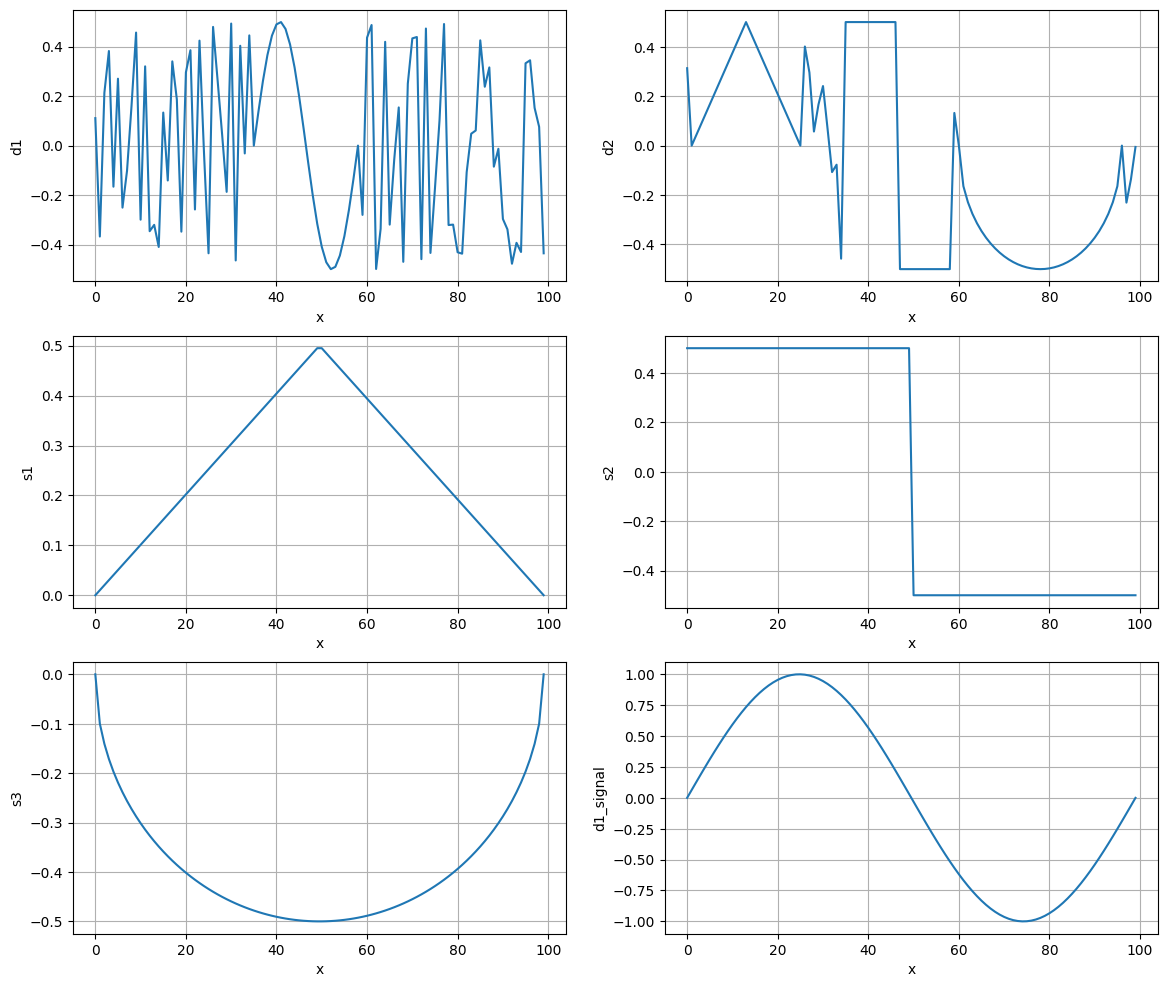

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(0,100,1)

plt.figure(figsize=(14, 12))

plt.subplot(3, 2, 1)
plt.plot(x,d1)
plt.xlabel('x')
plt.ylabel('d1')
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(x,d2)
plt.xlabel('x')
plt.ylabel('d2')
plt.grid(True)

y1 = []
for i in x:
    y1.append(s1(i/99))
plt.subplot(3, 2, 3)
plt.plot(x, y1)
plt.xlabel('x')
plt.ylabel('s1')
plt.grid(True)

y2 = []
for i in x:
    y2.append(s2(i/99))
plt.subplot(3, 2, 4)
plt.plot(x, y2)
plt.xlabel('x')
plt.ylabel('s2')
plt.grid(True)

y3 = []
for i in x:
    y3.append(s3(i/99))
plt.subplot(3, 2, 5)
plt.plot(x, y3)
plt.xlabel('x')
plt.ylabel('s3')
plt.grid(True)

plt.subplot(3, 2, 6)
plt.plot(x, np.sin(x*2*np.pi/99))
plt.xlabel('x')
plt.ylabel('d1_signal')
plt.grid(True)

plt.show()